In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

from utils import make_folder, extract_frames, crop_images, count_gray_levels

In [2]:
# #ONLY RUN ONCE
# #making folders
full_frames_name = 'sim_G1100'
cropped_frames_name = 'sim_G1100_crop'
make_folder(full_frames_name)
make_folder(cropped_frames_name)

FileExistsError: [Errno 17] File exists: 'sim_G1100'

In [45]:
# #ONLY RUN ONCE
# #extracting frames from the simulated 2 percent G1100 video
video_name = 'test2percent_G1100_cut'
path_to_source = 'data/' + video_name + '.avi'
full_frames_name = 'sim_G1100'
num_frames = 30
extract_frames(video_name, path_to_source, num_frames, full_frames_name)

No frames grabbed!


[ WARN:0@1033.395] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1033.395] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




In [3]:
# Function to increase contrast using histogram equalization
def increase_contrast(image):
    return cv.equalizeHist(image)

# Path to the folder containing the images
input_folder = 'sim_G1100'
output_folder = 'sim_G1100_high_contrast'
make_folder(output_folder)


# Iterate through the images in the input folder
for image_file in os.listdir(input_folder):
    # Read the RGB image
    image_path = os.path.join(input_folder, image_file)
    rgb_image = cv.imread(image_path)

    # Convert the RGB image to grayscale
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_BGR2GRAY)

    # Increase the contrast of the grayscale image
    contrast_image = increase_contrast(gray_image)

    # Save the processed image to the output folder
    output_path = os.path.join(output_folder, image_file)
    cv.imwrite(output_path, contrast_image)

In [4]:
#ONLY RUN ONCE
# crop images for faster calculation 
# x and y are flipped to my understanding 
data_path = 'sim_G1100_high_contrast/'
data_save = 'sim_G1100_crop_high_contrast/'
make_folder(data_save)
x_start = 0
x_end = 100
y_start = 0
y_end = 50
crop_images(data_path, data_save, x_start, x_end, y_start, y_end, color=False)

In [5]:
def read_frames_from_folder(folder_path):
    frames = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.jpg') or file.endswith('.png'):
            frame = cv.imread(os.path.join(folder_path, file), cv.IMREAD_GRAYSCALE)
            frames.append(frame)
    return frames
    

In [6]:
def calculate_arrival_times(frames, threshold):
    '''The threshold value corresponds to the intensity value used to determine the arrival time of the wave at each pixel.
    If the pixel intensity at a given location exceeds this threshold, it is considered that the wave has arrived at that pixel.
    The purpose of the threshold is to identify the point in time when the wave is considered to have reached the pixel,
    based on the intensity of the pixel in the frames.
    
    Llow threshold value might result in detecting noise or other irrelevant fluctuations in the image as the wave propagation,
    which can affect the accuracy of your arrival time calculations.
    It's important to choose an appropriate threshold value that allows you to distinguish the actual wave propagation
    from noise or other irrelevant fluctuations in the image. '''
    
    arrival_times = np.zeros(frames[0].shape)
    for y in range(frames[0].shape[0]):
        for x in range(frames[0].shape[1]):
            for t in range(len(frames)):
                if frames[t][y, x] >= threshold:
                    arrival_times[y, x] = t
                    break
    return arrival_times
    

In [7]:
def calculate_distances(y_source, frame_height, px2um):
    distances = np.zeros(frame_height)
    for y in range(frame_height):
        distances[y] = np.abs(y - y_source) * px2um
    return distances


In [8]:
def estimate_shear_wave_speed(arrival_times, distances, frame_rate):
    shear_wave_speed = np.zeros(arrival_times.shape)
    for y in range(arrival_times.shape[0]):
        for x in range(arrival_times.shape[1]):
            time_of_flight = arrival_times[y, x] / frame_rate
            shear_wave_speed[y, x] = distances[y] / time_of_flight
    return shear_wave_speed


In [9]:
folder_path = 'sim_G1100_crop_high_contrast'
frames = read_frames_from_folder(folder_path)
# get gray levels to decide on the "threshold"
max_intensity = count_gray_levels(frames[0])
max_intensity 

255

/var/folders/vj/3_h6tw0d0c54j62h3ppjflww0000gn/T/ipykernel_99809/2957147873.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  shear_wave_speed[y, x] = distances[y] / time_of_flight


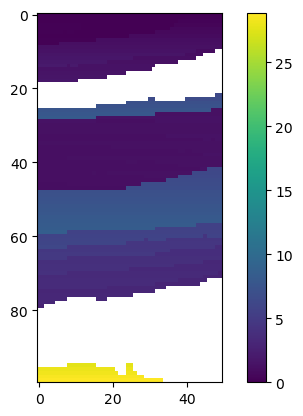

In [44]:
'''This script assumes that the wave source is at the top edge of the frames (y_source = 0) and propagates vertically downwards.
You need to adjust the threshold, frame_rate, and y_source based on your specific data and application.'''

folder_path = 'sim_G1100_crop_high_contrast'
frames = read_frames_from_folder(folder_path)

# # experimental videos
# threshold = 25 # Adjust this threshold based on your data
# frame_rate = 100e3  # Adjust the frame rate based on your data (in frames per second)
# y_source = 0  # Adjust the y-coordinate of the wave source
# px2um = 0.5*1e-6 # conversion factor for the pixels in SI units, here in [um]

# simulated videos
threshold = max_intensity // 2 # Adjust this threshold based on your data
frame_rate = 1/((1/12500)/30) # 12500*85)/(85/len(frames))  # Adjust the frame rate based on your data (in frames per second)
y_source = 0  # Adjust the y-coordinate of the wave source
px2m = (1/1.286)*1e-6 # conversion factor for the pixels in SI units, here in [m]


arrival_times = calculate_arrival_times(frames, threshold)
distances = calculate_distances(y_source, frames[0].shape[0], px2m)
shear_wave_speed = estimate_shear_wave_speed(arrival_times, distances, frame_rate)

# Remove infinite and NaN values due to division by zero
# shear_wave_speed = np.nan_to_num(shear_wave_speed, nan=0, posinf=0, neginf=0)

# Normalize and save the resulting shear wave speed map
# cv.normalize(shear_wave_speed, shear_wave_speed, 0, 255, cv.NORM_MINMAX)
# cv.imwrite('shear_wave_speed_map.png', shear_wave_speed)
plt.figure()
plt.imshow(shear_wave_speed)
plt.colorbar()


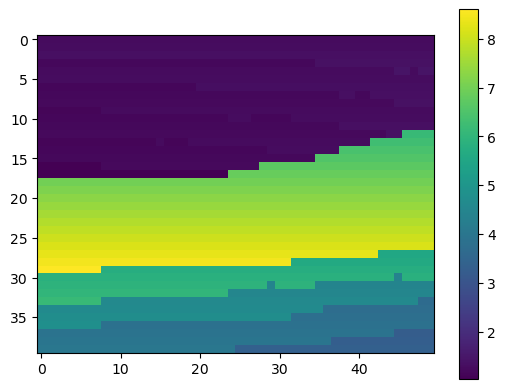

In [39]:
limited_shear_wave_speed = shear_wave_speed[30:70,:]
plt.figure()
plt.imshow(limited_shear_wave_speed)
plt.colorbar()

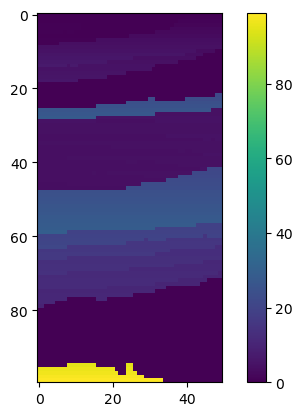

In [12]:
# Remove infinite and NaN values due to division by zero
shear_wave_speed = np.nan_to_num(shear_wave_speed, nan=0, posinf=0, neginf=0)

# Normalize and save the resulting shear wave speed map
# cv.normalize(shear_wave_speed, shear_wave_speed, 0, 255, cv.NORM_MINMAX)
# cv.imwrite('shear_wave_speed_map.png', shear_wave_speed)
plt.figure()
plt.imshow(shear_wave_speed)
plt.colorbar()

In [40]:
# finding median slope (positive), not including nan values
copy_shear_wave_speed = limited_shear_wave_speed

# nan_array = np.isnan(copy_shear_wave_speed)
# not_nan_array = ~ nan_array
# nan_array = np.isposinf(copy_shear_wave_speed)
# not_nan_array = ~ nan_array
# speed_notnan = copy_shear_wave_speed[not_nan_array]
# replacement_value = np.median(speed_notnan)
speed_notzeros = copy_shear_wave_speed[copy_shear_wave_speed != 0]
replacement_value = np.median(speed_notzeros)
print(replacement_value , speed_notzeros)


3.9657853810264383 [1.24972228 1.24972228 1.24972228 ... 3.35342146 3.35342146 3.35342146]


In [ ]:
# # finding median slope (positive), not including nan values
# copy_shear_wave_speed = shear_wave_speed

# # nan_array = np.isnan(copy_shear_wave_speed)
# # not_nan_array = ~ nan_array
# nan_array = np.isposinf(copy_shear_wave_speed)
# not_nan_array = ~ nan_array
# speed_notnan = copy_shear_wave_speed[not_nan_array]
# replacement_value = np.median(speed_notnan)
# # speed_notzeros = copy_shear_wave_speed[copy_shear_wave_speed != 0]
# # replacement_value = np.median(speed_notzeros)
# print(replacement_value , speed_notnan)

In [41]:
#same value as above
for i in range(copy_shear_wave_speed.shape[0]):
    for j in range(copy_shear_wave_speed.shape[1]):
        if copy_shear_wave_speed[i,j]>10*replacement_value:
            copy_shear_wave_speed[i,j] = replacement_value
        elif np.isnan(copy_shear_wave_speed[i,j]):
            copy_shear_wave_speed[i,j] = replacement_value
copy_shear_wave_speed

array([[1.24972228, 1.24972228, 1.24972228, ..., 1.24972228, 1.24972228,
        1.24972228],
       [1.29137969, 1.29137969, 1.29137969, ..., 1.29137969, 1.29137969,
        1.29137969],
       [1.3330371 , 1.3330371 , 1.3330371 , ..., 1.3330371 , 1.3330371 ,
        1.3330371 ],
       ...,
       [3.90746501, 3.90746501, 3.90746501, ..., 3.25622084, 3.25622084,
        3.25622084],
       [3.96578538, 3.96578538, 3.96578538, ..., 3.30482115, 3.30482115,
        3.30482115],
       [4.02410575, 4.02410575, 4.02410575, ..., 3.35342146, 3.35342146,
        3.35342146]])

In [42]:
# calculate elasticity
def elasticity_HT (speed, density):
    mu = (speed **2) * density
    return mu

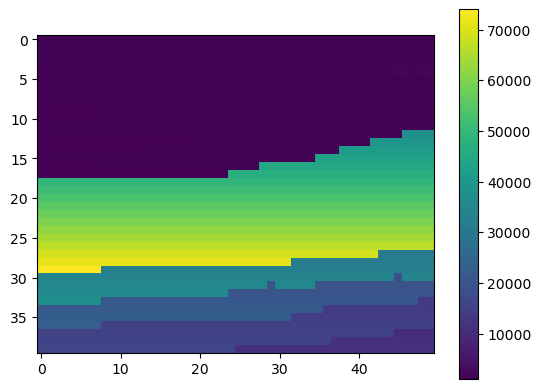

In [43]:
# Compute elasticity
density = 1000
mu = elasticity_HT(copy_shear_wave_speed, density) 
mu_2dec = np.round(mu,2)
plt.figure()
plt.imshow(mu_2dec)
plt.colorbar()

In [33]:
def get_non_zero_elements(array):
    non_zero_indices = np.nonzero(array)
    non_zero_values = array[non_zero_indices]
    return non_zero_values

In [34]:
mu_nonzero = get_non_zero_elements(mu_2dec)
mu_median = np.median(mu_nonzero)
mu_median

nan